In [1]:
import pandas as pd
import tensorboard as tb
import seaborn as sns
from matplotlib import pyplot as plt
from tensorboard.backend.event_processing import event_accumulator as ea
from pathlib import Path

In [2]:
# take every X sample for plot (raw log interval: 20k frames) default: 6
DATA_PLOT_SPARSITY = 4

# rolling average sample window (applied after sparsity) default: 4
DATA_PLOT_SMOOTHNESS = 6

# in and out dirs
logs_dir = Path.home() / Path("ordner", "mthesis", "live_scobi_logs")
out_dir = Path.cwd() / Path("plots")

# envs to look for in logdir and subdirs and plot
envs = ["pong", "boxing", "skiing"]

# experiments to exclude from plots:
dont_plot = []

# scalars to look for in tfevent files and plot
scalars_to_plot = {"rewards/avg_return":
                       {"title" : "Trajectory Return",
                        "xlabel": "Frames (M)",
                        "ylabel": "Score"},
                   "various/avg_steps":
                       {"title" : "Trajectory Length",
                        "xlabel": "Frames (M)",
                        "ylabel": "Steps"},
                  "loss/avg_policy_net_entropy":
                       {"title" : "Policy MLP Entropy",
                        "xlabel": "Frames (M)",
                        "ylabel": "Entropy"},
                  "loss/avg_value_net":
                       {"title" : "Value MLP Loss",
                        "xlabel": "Frames (M)",
                        "ylabel": "MSE"}}



In [3]:
# for one env
def get_dfs_for_env(env, sca2p, everyx=5, smooth_window=5):
    exp_list = []
    for p in logs_dir.rglob("*"):
        if p.is_file():
            if env in str(p.parents[0].name):
                split_name = p.parents[0].name.split("seed")
                seed = split_name[-1]
                exp_name = split_name[0]
                if p.parents[0].name in dont_plot:
                    continue
                exp_list.append((seed, p.parents[0]))
    if len(exp_list) == 0:
        return None
    exp_str_list = " ".join([str(n[0]) for n in exp_list])
    
    # {seed : [(tag, s.step, s.value, seed),...]}
    data_dict = {}
    for seed, log_dir in exp_list:
        if "pruned" in log_dir.name:
            scobi_mode = "1"
        else:
            scobi_mode = "0"
        for file in log_dir.iterdir():
            if 'tfevents' in file.name:
                acc = ea.EventAccumulator(str(file))
                acc.Reload()
                scalar_list = acc.Tags()['scalars']
                for tag in scalar_list:
                    for s in acc.Scalars(tag):
                        key = seed + "_" + scobi_mode
                        if key in data_dict.keys():
                            data_dict[key].append((tag, s.step, s.value, seed, scobi_mode, s.wall_time))
                        else:
                            data_dict[key] = []
    scobi_seeds = []
    iscobi_seeds = []
    for k in data_dict.keys():
        splitlist = k.split("_")
        if splitlist[-1] == "0":
            scobi_seeds.append(splitlist[0])
        if splitlist[-1] == "1":
            iscobi_seeds.append(splitlist[0])
    scobi_seeds = ' '.join(sorted(scobi_seeds))
    iscobi_seeds = ' '.join(sorted(iscobi_seeds))      
    print(f"Environment: {env}\t|\tSeeds: scobi: {scobi_seeds} \tiscobi: {iscobi_seeds}")
    # extracts scalar samples from df,
    # processes them (skipping and smoothing)
    # and appends them to dict value : {scalar_name : [scalar_df, ..]}
    def scalars_to_df(df, scalars, out_df_dict):
        for s in scalars:
            scalar_df = df[df["tag"] == s].copy()            
            scalar_df = scalar_df.sort_values(by=["step", "wall_time"], ascending=True)
            scalar_df = scalar_df.drop_duplicates(subset=['step'], keep="last")
            scalar_df = scalar_df.iloc[::everyx, :]
            scalar_df["value"] = scalar_df.value.rolling(smooth_window, min_periods=1).mean()
            if s in out_df_dict.keys():
                out_df_dict[s].append(scalar_df)
            else:
                out_df_dict[s] = [scalar_df]
    
    scalar_dict = {}    
    # {scalar_name : [scalar_df_seedX, ..],
    #  scalar_name2 : [scalar_df_seedX, ..]}
    for k, v in data_dict.items():
        df = pd.DataFrame(v, columns=["tag", "step", "value", "seed", "scobi_mode", "wall_time"])
        df.step = df.step / 1000000
        scalars_to_df(df, sca2p, scalar_dict)

    # merge seed df's of one scalar to one df, inplace
    scalar_dict.update((k, pd.concat(v, ignore_index=True)) for k, v in scalar_dict.items())
    return scalar_dict

In [4]:
data_to_plot = {}

# goes over every specified env and
# creates dict: {env : {scalar1 : df, scalar2 : df, ...}, env2 : {scalar1 : df, scalar2 :df, ...}, ...}
for e in envs:
    res_dict = get_dfs_for_env(e, scalars_to_plot.keys(), DATA_PLOT_SPARSITY, DATA_PLOT_SMOOTHNESS)
    if res_dict:
        data_to_plot[e] = res_dict

Environment: pong	|	Seeds: scobi: 7 8 9 	iscobi: 7 8 9
Environment: boxing	|	Seeds: scobi: 7 8 9 	iscobi: 7 8 9


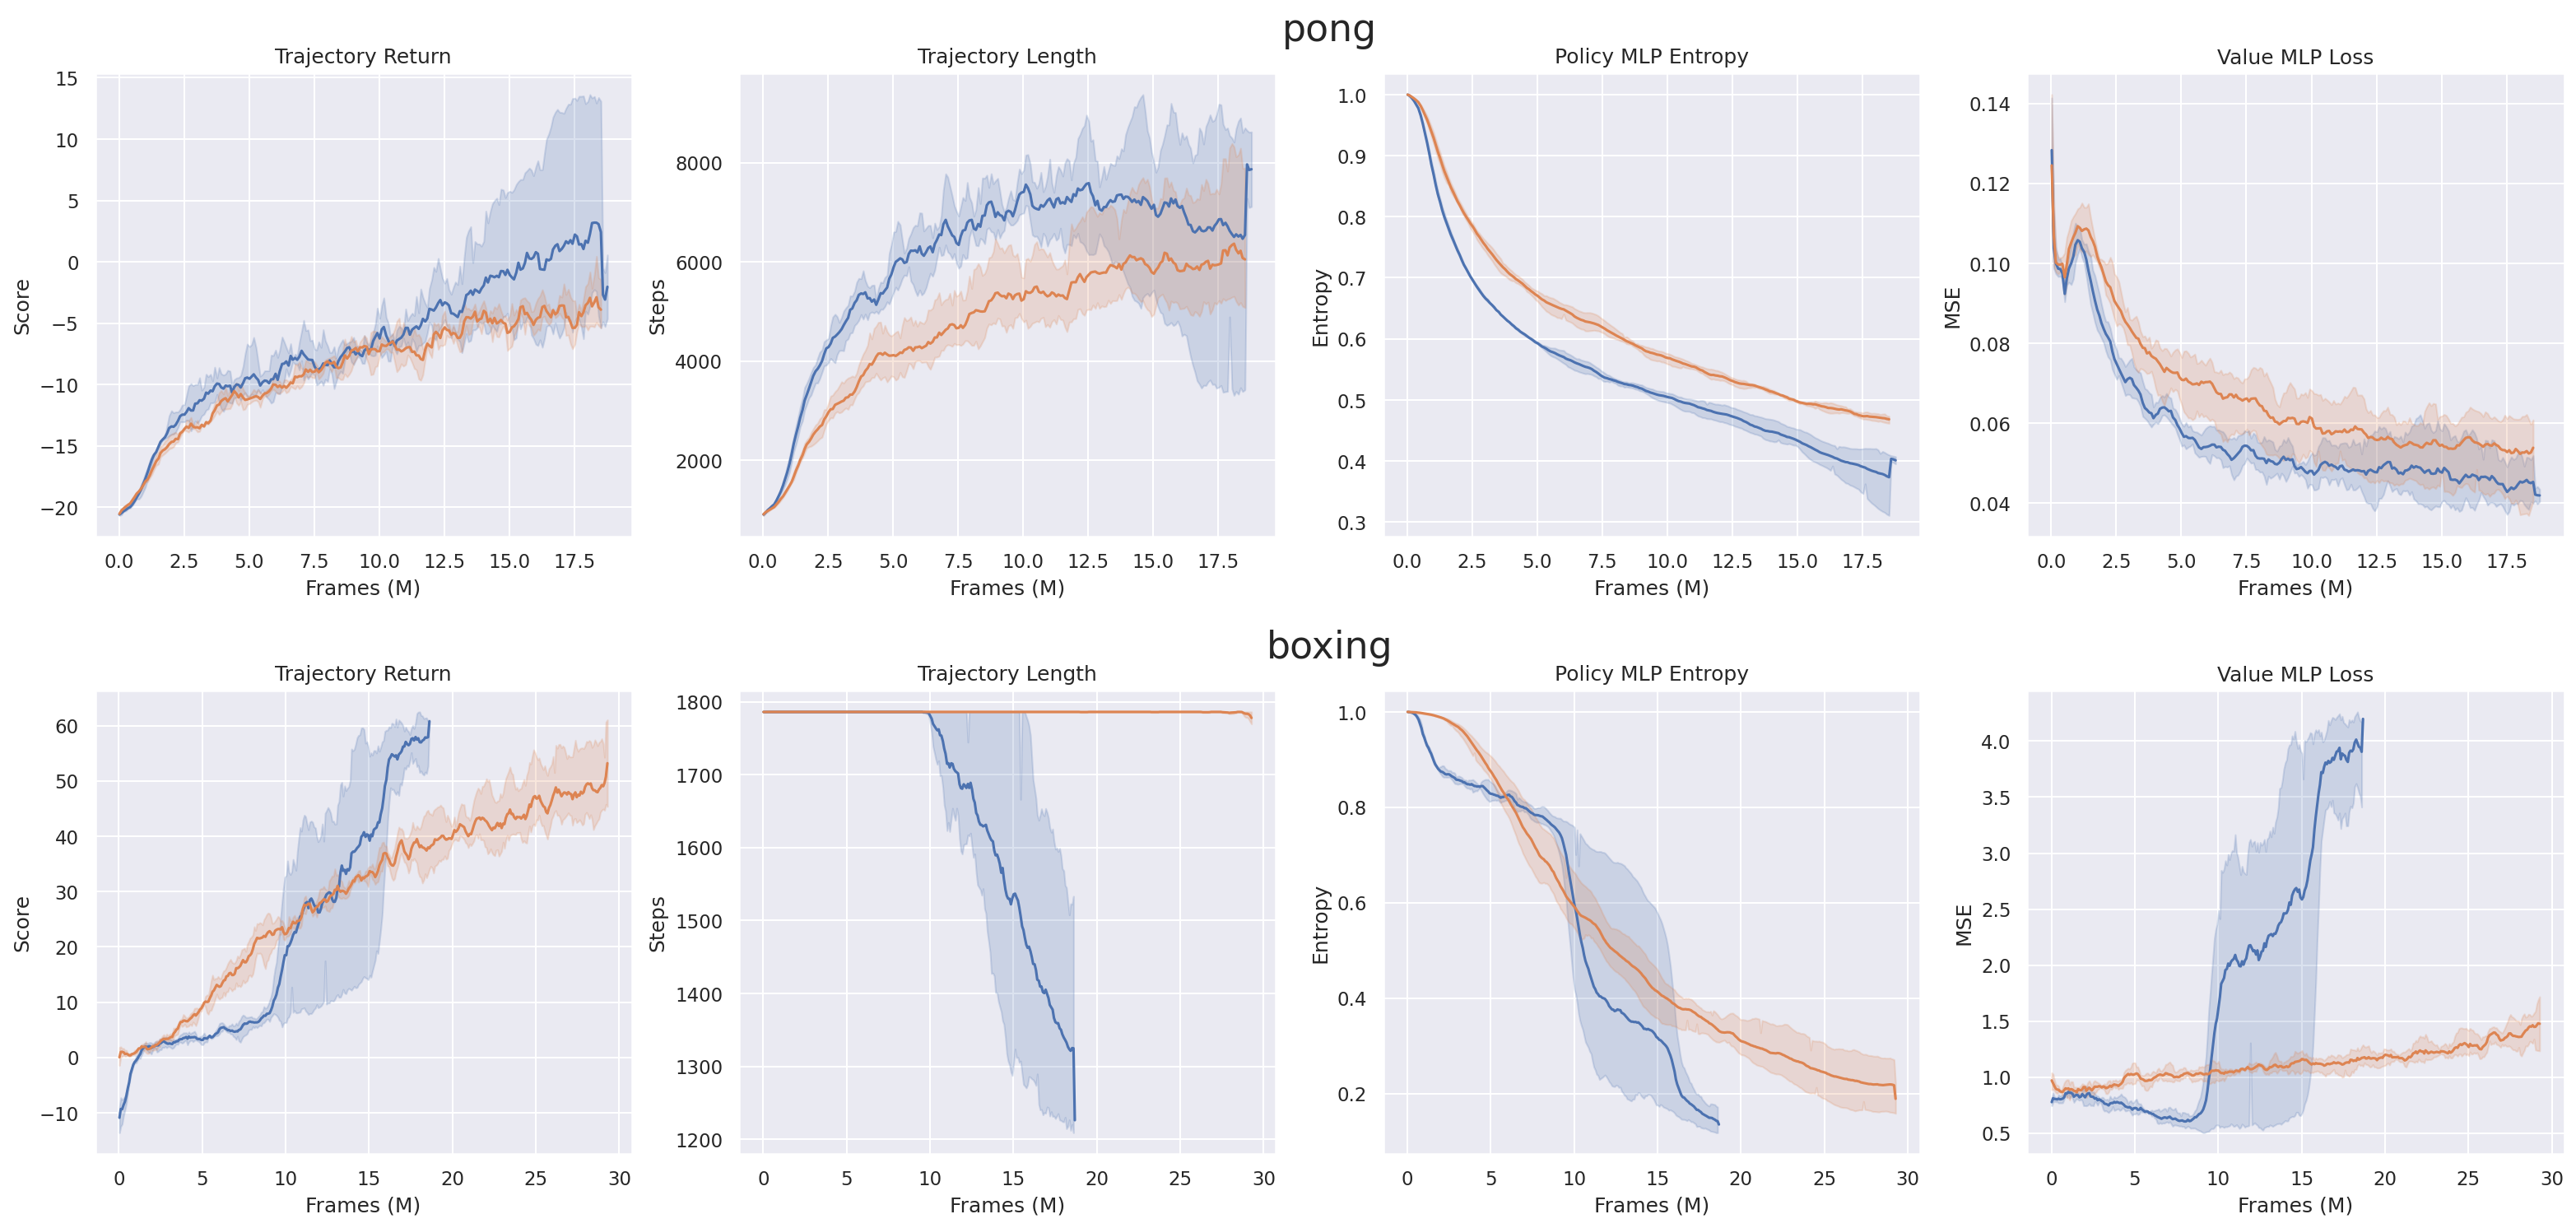

In [5]:
sns.set_theme()
fig_width = 20
no_envs = len(data_to_plot)
no_scalars = len(scalars_to_plot)
width_per_plot = fig_width / no_scalars
fig_size = (fig_width, no_envs * width_per_plot)
fig = plt.figure(figsize=fig_size, dpi=150)
subfigs = fig.subfigures(no_envs, 1)
# env interator
for i, (k, v) in enumerate(data_to_plot.items()):
    subfigs[i].suptitle(str(k), fontsize=22, y=1)
    axes = subfigs[i].subplots(1, no_scalars)
    # scalar iterator
    for j, (s_name, s_descriptions) in enumerate(scalars_to_plot.items()):
        s_plt = sns.lineplot(data=v[s_name], x="step", y="value", hue="scobi_mode", ax=axes[j])
        axes[j].get_legend().remove()
        s_plt.set(
            xlabel = s_descriptions["xlabel"],
            ylabel = s_descriptions["ylabel"],
            title  = s_descriptions["title"])

plt.subplots_adjust(top = 0.9, bottom=0.15, left=0, right=1)
plt.show(fig)
fig.savefig(out_dir / "results.png", bbox_inches='tight')